## Install Required Libraries

In [1]:
!pip install matplotlib seaborn scikit-learn graphviz


## Random Forest with Hyperparameter Optimization & Visualization

### Load Libraries & View the Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import plot_tree

# Load dataset
data = pd.read_csv('/content/UsedCars.csv')

print("----------- View the First Five Rows of the Data --------------")
print(data.head())

print("------------- Data Information Check of Size and Completeness --------------")
print(data.info())



----------- View the First Five Rows of the Data --------------
   Year       Make         Model  Price  Number of Owners           Use  \
0  2011  Chevrolet  Silverado LT   9988                 2  Personal Use   
1  2008     Toyota    Corolla CE   7995                 2  Multiple Use   
2  2012        Kia        Rio LX   4995                 2  Personal Use   
3  2018     Nissan      Rogue SL   7980                 1  Personal Use   
4  2018    Hyundai    Tucson SEL   9775                 1  Personal Use   

     Body  Mileage Damage Accident Purchase  
0  Pickup   125210    Yes       No       No  
1   Sedan   121681     No       No      Yes  
2   Sedan   140401     No       No       No  
3     SUV   213787     No       No       No  
4     SUV   147815     No       No       No  
------------- Data Information Check of Size and Completeness --------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 11 columns):
 #   Column            Non-Nu

### Data Preparation for Modeling Including Feature Engineering


In [3]:
# Subset or filter to specific columns of interest
data = data[['Year', 'Make', 'Price', 'Number of Owners', 'Use', 'Body', 'Mileage', 'Damage', 'Purchase']]

# Feature engineering age
data.loc[:, 'Age'] = 2025 - data['Year']

# Selecting factors or features for the model
data = data[['Age', 'Make', 'Price', 'Number of Owners', 'Use', 'Body', 'Mileage', 'Damage', 'Purchase']]

# Specify columns with "Yes" and "No" values to map to binary
binary_cols = ['Purchase', 'Damage']  # Add any other "Yes"/"No" columns here

# Map binary columns to 0 and 1
for col in binary_cols:
    data[col] = data[col].map({'No': 0, 'Yes': 1})

# Separate features and target
X = data.drop(['Purchase'], axis=1)
y = data['Purchase']

# Define categorical columns to one-hot encode (excluding binary-encoded columns)
categorical_cols = ['Make', 'Use', 'Body']
numeric_cols = ['Age', 'Price', 'Number of Owners', 'Mileage']

# One-hot encode the categorical columns
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X[categorical_cols])

# Convert the encoded data to a DataFrame with feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names, index=X.index)

# # Concatenate the encoded categorical data with the numeric and binary columns
X_final = pd.concat([X[numeric_cols + [binary_cols[1]]], X_encoded_df], axis=1)

print("-------------Input Data After Transformations ------------")
print(X_final.head())



-------------Input Data After Transformations ------------
   Age  Price  Number of Owners  Mileage  Damage  Make_Audi  Make_BMW  \
0   14   9988                 2   125210     1.0        0.0       0.0   
1   17   7995                 2   121681     0.0        0.0       0.0   
2   13   4995                 2   140401     0.0        0.0       0.0   
3    7   7980                 1   213787     0.0        0.0       0.0   
4    7   9775                 1   147815     0.0        0.0       0.0   

   Make_BMW   Make_Buick  Make_Cadillac  ...  Use_Personal Use  \
0        0.0         0.0            0.0  ...               1.0   
1        0.0         0.0            0.0  ...               0.0   
2        0.0         0.0            0.0  ...               1.0   
3        0.0         0.0            0.0  ...               1.0   
4        0.0         0.0            0.0  ...               1.0   

   Use_Rental Use  Body_Coupe  Body_Hatchback  Body_Minivan  Body_Pickup  \
0             0.0         0.0

<ipython-input-3-bcdd7fa924b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Age'] = 2025 - data['Year']


### Training the Random Forest Model

In [4]:
# Continue with splitting the data, training, and evaluating the model as before
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

# Predict on test set
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


## Accuracy Assessment - Confusion Matrix & ROC

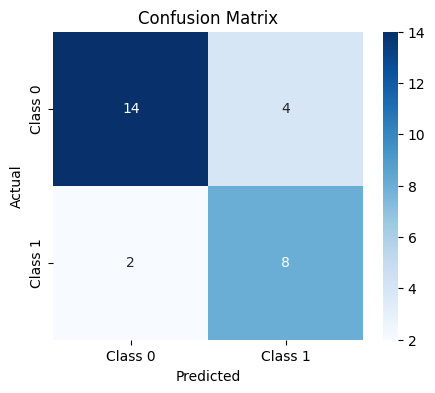

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.82        18
           1       0.67      0.80      0.73        10

    accuracy                           0.79        28
   macro avg       0.77      0.79      0.78        28
weighted avg       0.80      0.79      0.79        28



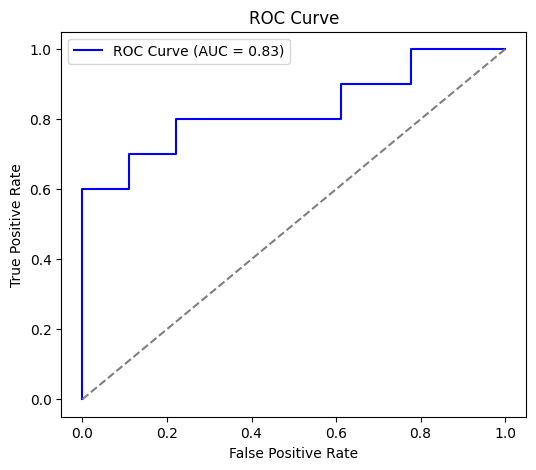

In [5]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## View the first three trees

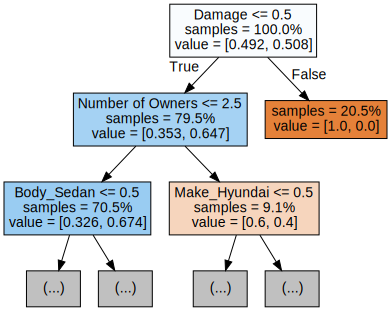

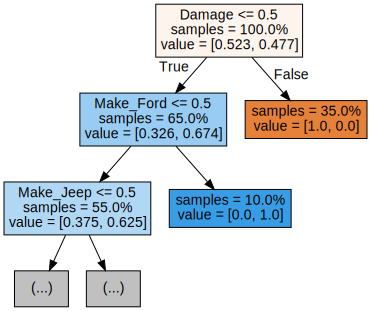

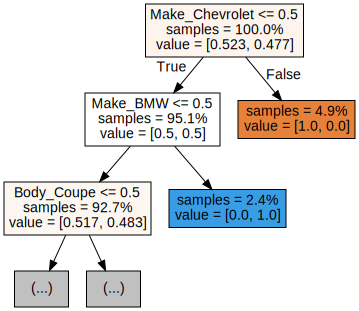

In [6]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Visualizing the First Three Decision Trees
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)